Using data from: /content/drive/MyDrive/brainTumorDataPublic_1766
Output images will be saved in: /content/brain_tumor_images


100%|██████████| 766/766 [00:36<00:00, 21.06it/s]


 All .mat files converted to .jpg and organized by label!
Showing sample images for each tumor class:


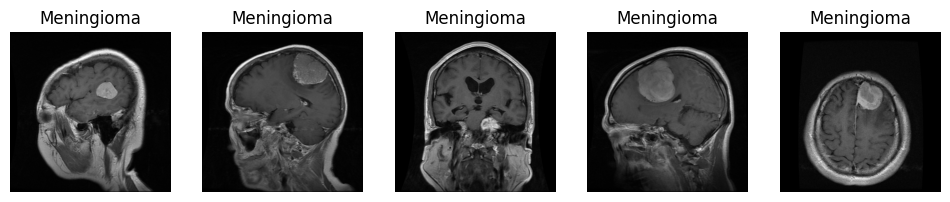

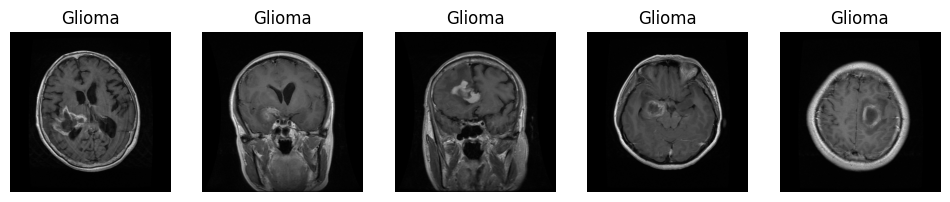

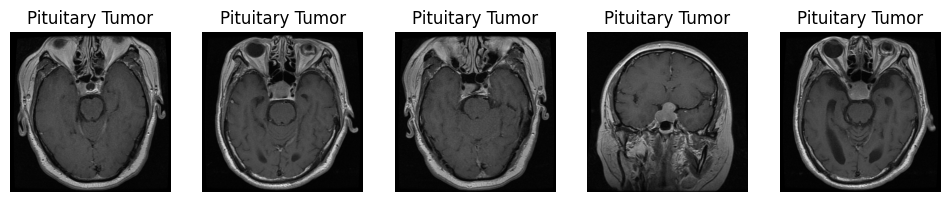

Conversion complete — dataset ready for training!


In [20]:
#Brain Tumor MRI Dataset - HDF5 (.mat v7.3) Reader + JPG Converter

#Step 1: Install dependencies
!pip install scipy numpy opencv-python matplotlib tqdm h5py

#Step 2: Imports
import os
import h5py
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm

#Step 3: Define paths
input_folder = "/content/drive/MyDrive/brainTumorDataPublic_1766"
output_folder = "/content/brain_tumor_images"

os.makedirs(output_folder, exist_ok=True)

print(f"Using data from: {input_folder}")
print(f"Output images will be saved in: {output_folder}")

#Step 4: Convert .mat → .jpg
for file_name in tqdm(os.listdir(input_folder)):
    if file_name.endswith(".mat"):
        file_path = os.path.join(input_folder, file_name)
        try:
            with h5py.File(file_path, "r") as f:
                # Access the structure
                cjdata = f["cjdata"]

                # Extract image data )
                image = np.array(cjdata["image"]).T
                label = int(np.array(cjdata["label"])[0][0])

                # Normalize to 0–255 range
                im1 = image.astype(np.float64)
                im1 = 255 * (im1 - im1.min()) / (im1.max() - im1.min())
                im = im1.astype(np.uint8)

                # Save image to correct label folder
                label_folder = os.path.join(output_folder, str(label))
                os.makedirs(label_folder, exist_ok=True)

                base_name = os.path.splitext(file_name)[0]
                cv2.imwrite(os.path.join(label_folder, f"{base_name}.jpg"), im)

        except Exception as e:
            print(f" Error processing {file_name}: {e}")

print(" All .mat files converted to .jpg and organized by label!")


#Step 5: Preview samples
label_map = {1: "Meningioma", 2: "Glioma", 3: "Pituitary Tumor"}

def show_samples(label):
    path = os.path.join(output_folder, str(label))
    samples = os.listdir(path)[:5]
    plt.figure(figsize=(12, 4))
    for i, img_name in enumerate(samples):
        img = cv2.imread(os.path.join(path, img_name), cv2.IMREAD_GRAYSCALE)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img, cmap="gray")
        plt.axis("off")
        plt.title(label_map[label])
    plt.show()

print("Showing sample images for each tumor class:")
for lbl in [1, 2, 3]:
    show_samples(lbl)

print("Conversion complete — dataset ready for training!")



In [21]:
import shutil

# Source (Colab temporary storage)
src_folder = "/content/brain_tumor_images"

# Destination (Google Drive)
dst_folder = "/content/drive/MyDrive/brain_tumor_images_final"

# Copy all images to Drive
if os.path.exists(src_folder):
    shutil.copytree(src_folder, dst_folder, dirs_exist_ok=True)
    print(f"All images copied to Google Drive at:\n{dst_folder}")
else:
    print("No converted images found in /content/brain_tumor_images. Run the conversion first.")


All images copied to Google Drive at:
/content/drive/MyDrive/brain_tumor_images_final


 Loaded 67 images (sample preview set).


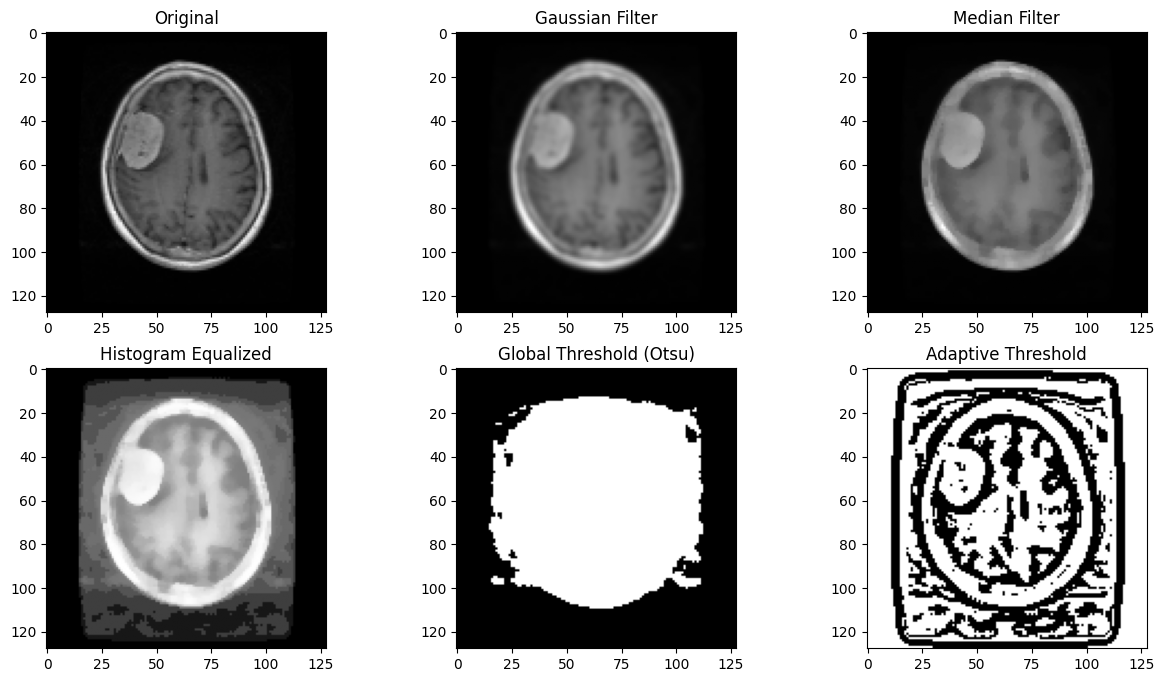

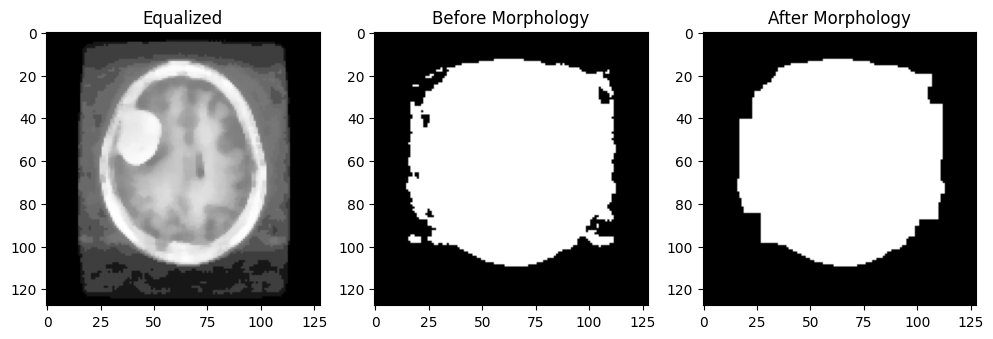

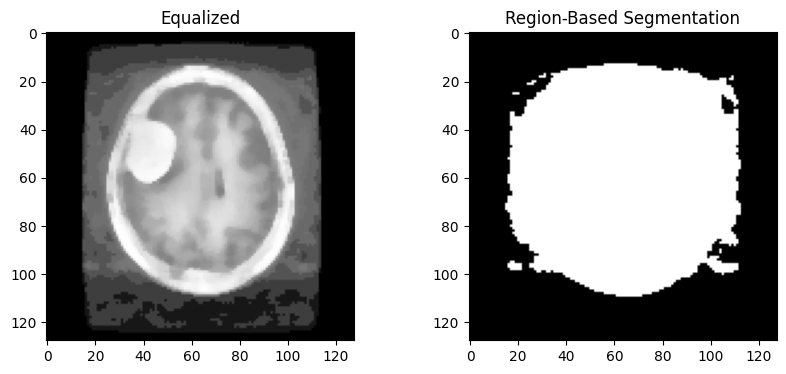

Dice Similarity (Gaussian vs Median): 0.9896


In [22]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

# --- Step 1: Set path to your saved data ---
data_dir = "/content/drive/MyDrive/brain_tumor_images_final"  # use your saved Drive folder

# --- Step 2: Pick a small subset for demo (you can scale later) ---
all_images = []
labels = []
for lbl in ['1', '2', '3']:
    folder = os.path.join(data_dir, lbl)
    for img_file in os.listdir(folder)[:30]:  # limit for preview
        img_path = os.path.join(folder, img_file)
        all_images.append(img_path)
        labels.append(lbl)

print(f" Loaded {len(all_images)} images (sample preview set).")

# --- Step 3: Define preprocessing functions ---

def preprocess_image(img_path, size=(128,128)):
    """Load, resize, normalize grayscale image."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, size)
    img = img / 255.0
    return img

def apply_filters(img):
    """Compare Gaussian and Median filtering."""
    gaussian = cv2.GaussianBlur(img, (5,5), 0)
    median = cv2.medianBlur((img*255).astype(np.uint8), 5)
    return gaussian, median / 255.0

def enhance_contrast(img):
    """Histogram Equalization."""
    img_8bit = (img * 255).astype(np.uint8)
    equalized = cv2.equalizeHist(img_8bit)
    return equalized / 255.0

def segment_threshold(img):
    """Compare Global vs Adaptive Thresholding."""
    img_8bit = (img * 255).astype(np.uint8)
    _, global_thresh = cv2.threshold(img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adaptive = cv2.adaptiveThreshold(img_8bit, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                     cv2.THRESH_BINARY, 11, 2)
    return global_thresh, adaptive

#  Step 4: Visualize example pipeline on 1 sample image

sample_path = all_images[0]
original = preprocess_image(sample_path)
gaussian, median = apply_filters(original)
equalized = enhance_contrast(median)
global_thresh, adaptive_thresh = segment_threshold(equalized)

#Step 5: Plot results
plt.figure(figsize=(15,8))
plt.subplot(2,3,1); plt.imshow(original, cmap='gray'); plt.title("Original")
plt.subplot(2,3,2); plt.imshow(gaussian, cmap='gray'); plt.title("Gaussian Filter")
plt.subplot(2,3,3); plt.imshow(median, cmap='gray'); plt.title("Median Filter")
plt.subplot(2,3,4); plt.imshow(equalized, cmap='gray'); plt.title("Histogram Equalized")
plt.subplot(2,3,5); plt.imshow(global_thresh, cmap='gray'); plt.title("Global Threshold (Otsu)")
plt.subplot(2,3,6); plt.imshow(adaptive_thresh, cmap='gray'); plt.title("Adaptive Threshold")
plt.show()

#Step 6: Morphological Refinement
def refine_segmentation(thresh_img):
    kernel = np.ones((3,3), np.uint8)
    opened = cv2.morphologyEx(thresh_img, cv2.MORPH_OPEN, kernel, iterations=2)
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel, iterations=2)
    return closed

refined_mask = refine_segmentation(global_thresh)

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(equalized, cmap='gray'); plt.title("Equalized")
plt.subplot(1,3,2); plt.imshow(global_thresh, cmap='gray'); plt.title("Before Morphology")
plt.subplot(1,3,3); plt.imshow(refined_mask, cmap='gray'); plt.title("After Morphology")
plt.show()

# --- Step 7: Region-Based Segmentation ---
def region_based_segmentation(img):
    img_8bit = (img * 255).astype(np.uint8)
    ret, thresh = cv2.threshold(img_8bit, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros_like(img_8bit)
    cv2.drawContours(mask, contours, -1, 255, -1)
    return mask, contours

region_mask, contours = region_based_segmentation(equalized)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.imshow(equalized, cmap='gray'); plt.title("Equalized")
plt.subplot(1,2,2); plt.imshow(region_mask, cmap='gray'); plt.title("Region-Based Segmentation")
plt.show()

# --- Step 8: Quantitative Comparison of Filters ---
def dice_score(mask1, mask2):
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)
    intersection = np.logical_and(mask1, mask2).sum()
    return (2. * intersection) / (mask1.sum() + mask2.sum() + 1e-8)

gaussian_mask, _ = segment_threshold(gaussian)
median_mask, _ = segment_threshold(median)
dice_val = dice_score(gaussian_mask, median_mask)
print(f"Dice Similarity (Gaussian vs Median): {dice_val:.4f}")





Processing label 3: 100%|██████████| 7/7 [00:00<00:00, 56.40it/s]


 Data loaded and normalized: (766, 128, 128, 1) labels: [0 1 2]
Train: 536, Val: 115, Test: 115


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.8260 - loss: 0.6550 - val_accuracy: 0.9304 - val_loss: 0.3237
Epoch 2/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9307 - loss: 0.3217 - val_accuracy: 0.9304 - val_loss: 0.2372
Epoch 3/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9020 - loss: 0.3330 - val_accuracy: 0.9304 - val_loss: 0.2120
Epoch 4/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 18s 1s/step - accuracy: 0.9115 - loss: 0.2778 - val_accuracy: 0.9304 - val_loss: 0.2158
Epoch 5/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 20s 1s/step - accuracy: 0.9153 - loss: 0.2327 - val_accuracy: 0.9652 - val_loss: 0.1807
Epoch 6/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step - accuracy: 0.9388 - loss: 0.2149 - val_accuracy: 0.9652 - val_loss: 0.1665
Epoch 7/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 16s 977ms/step - accuracy: 0.9343 - loss: 0.1744 - val_accuracy: 0.9565 - val_loss: 0.1407
Epoch 8/15
17/17 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9389 - loss: 0.1435 - val_accuracy: 0.9478 - val_lo

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 212ms/step
 Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.99      1.00       109
           2       0.83      1.00      0.91         5
           3       1.00      1.00      1.00         1

    accuracy                           0.99       115
   macro avg       0.94      1.00      0.97       115
weighted avg       0.99      0.99      0.99       115



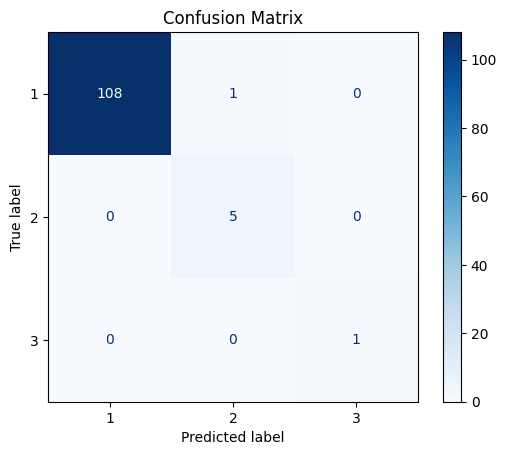

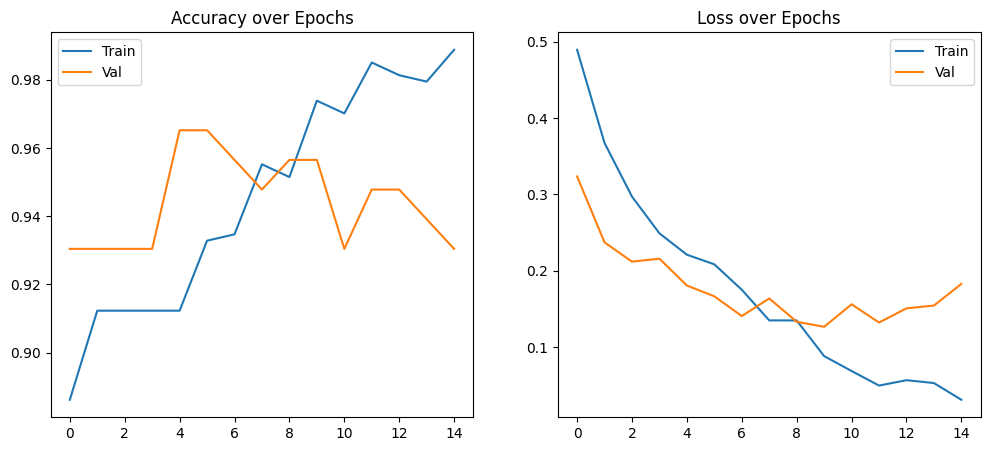

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step - accuracy: 0.6159 - loss: 0.8957 - val_accuracy: 0.7143 - val_loss: 0.7098
Epoch 2/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 880ms/step - accuracy: 0.7460 - loss: 0.6237 - val_accuracy: 0.7143 - val_loss: 0.7126
Epoch 3/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 1s/step - accuracy: 0.7705 - loss: 0.5759 - val_accuracy: 0.7143 - val_loss: 0.6322
Epoch 4/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 801ms/step - accuracy: 0.7747 - loss: 0.5297 - val_accuracy: 0.7143 - val_loss: 0.5933
Epoch 5/5
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 855ms/step - accuracy: 0.7649 - loss: 0.4744 - val_accuracy: 0.7143 - val_loss: 0.5429
 Raw CNN Accuracy: 0.8491
 Preprocessed CNN Accuracy: 0.9913


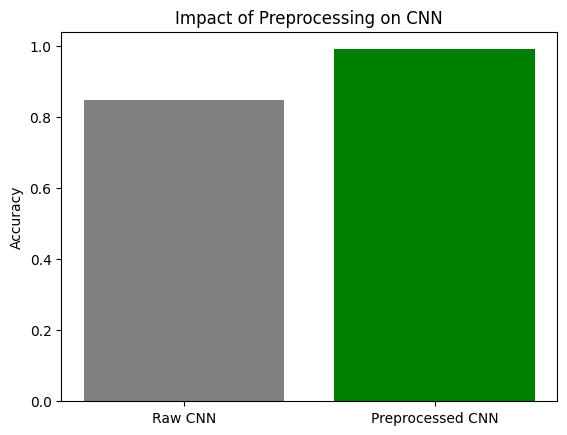

 Model saved to Drive successfully!


In [23]:

#Phase 2: CNN Model Training on Brain MRI Data

import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import os
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

#Step 1: Set data directory
data_dir = "/content/drive/MyDrive/brain_tumor_images_final"  # same folder as before

#Step 2: Load and preprocess all images
IMG_SIZE = (128, 128)
X = []
y = []

for label in ['1', '2', '3']:
    folder = os.path.join(data_dir, label)
    for img_file in tqdm(os.listdir(folder), desc=f"Processing label {label}"):
        img_path = os.path.join(folder, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, IMG_SIZE)
            img = img / 255.0
            X.append(img)
            y.append(label)

X = np.array(X).reshape(-1, 128, 128, 1)
le = LabelEncoder()
y = le.fit_transform(y)
print(" Data loaded and normalized:", X.shape, "labels:", np.unique(y))

#Step 3: Train-validation-test split
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
print(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}")

# Step 4: Define CNN architecture
def build_cnn_model():
    model = models.Sequential([
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D(2,2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(3, activation='softmax')  # 3 classes
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_cnn_model()
model.summary()

#Step 5: Train CNN
EPOCHS = 15
BATCH_SIZE = 32

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

#Step 6: Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Extra Evaluation Metrics ---
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(model.predict(X_test), axis=1)
print(" Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.show()

#Step 7: Plot accuracy & loss curves ---
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Val')
plt.title("Accuracy over Epochs")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.title("Loss over Epochs")
plt.legend()
plt.show()


#Step 9: Compare CNN With and Without Preprocessing ---
X_raw = []
y_raw = []

for label in ['1','2','3']:
    folder = os.path.join(data_dir, label)
    files = os.listdir(folder)[:200]
    for img_file in files:
        path = os.path.join(folder, img_file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (128,128))
            X_raw.append(img)
            y_raw.append(label)

X_raw = np.array(X_raw).reshape(-1,128,128,1)/255.0
y_raw = le.transform(y_raw)

# Split and train
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_raw, y_raw, test_size=0.2, random_state=42)
model_raw = build_cnn_model()
model_raw.fit(X_train_r, y_train_r, validation_split=0.2, epochs=5, batch_size=32, verbose=1)

# Evaluate both models
raw_acc = model_raw.evaluate(X_test_r, y_test_r, verbose=0)[1]
prep_acc = model.evaluate(X_test, y_test, verbose=0)[1]
print(f" Raw CNN Accuracy: {raw_acc:.4f}")
print(f" Preprocessed CNN Accuracy: {prep_acc:.4f}")

plt.bar(['Raw CNN', 'Preprocessed CNN'], [raw_acc, prep_acc], color=['gray','green'])
plt.ylabel("Accuracy"); plt.title("Impact of Preprocessing on CNN"); plt.show()


#  Step 8: Save model
model.save("/content/drive/MyDrive/brain_tumor_cnn_model.h5")
print(" Model saved to Drive successfully!")


In [24]:
from tensorflow import keras
import numpy as np

#Load your Sequential model
old_model = keras.models.load_model("/content/drive/MyDrive/brain_tumor_cnn_model.h5")
print("Original Sequential model loaded")

#Infer input shape
input_shape = (128, 128, 1)

#Rebuild as Functional
inputs = keras.Input(shape=input_shape, name="image_input")
x = inputs
for layer in old_model.layers:
    x = layer(x)
new_model = keras.Model(inputs=inputs, outputs=x, name="functional_brain_tumor_cnn")

# Sanity test
dummy = np.zeros((1, 128, 128, 1), dtype=np.float32)
_ = new_model.predict(dummy, verbose=0)
print("Rebuilt functional model ready for Grad-CAM")

#Save new version once
new_model.save("/content/drive/MyDrive/brain_tumor_cnn_functional.h5")
print(" Saved functional version for future use.")


Original Sequential model loaded
Rebuilt functional model ready for Grad-CAM
 Saved functional version for future use.


In [25]:
#  Grad-CAM++ (Top & Bottom Confidence + CSV + Debug Summary)

import numpy as np, tensorflow as tf, cv2, os, random, pandas as pd, matplotlib.pyplot as plt
from tensorflow import keras
#  STEP 1: Load model
model_path = "/content/drive/MyDrive/brain_tumor_cnn_model.h5"
model = keras.models.load_model(model_path)

# quick test run
dummy_input = np.zeros((1,128,128,1), dtype=np.float32)
_ = model.predict(dummy_input, verbose=0)
print(" Model loaded and tested successfully!\n")
#  Print model structure
def print_model_tree(model, indent=0):
    for layer in model.layers:
        print(" " * indent + f"- {layer.name} ({layer.__class__.__name__})")
print(" MODEL STRUCTURE:")
print_model_tree(model)
print()
#Find last Conv layer
def find_last_conv_layer(model):
    for layer in reversed(model.layers):
        if isinstance(layer, keras.layers.Conv2D):
            print(f" Using last convolution layer: {layer.name}")
            return layer.name
    raise ValueError(" No Conv2D layer found!")

#Grad-CAM++ (manual forward pass, Sequential-safe)

def make_gradcam_heatmap_manual(img_array, model, last_conv_layer_name, use_gradcampp=True):
    """Manual forward pass through Sequential model — no symbolic graph building."""
    img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)

    with tf.GradientTape() as tape:
        x = img_tensor
        conv_output = None
        for layer in model.layers:
            x = layer(x)
            if layer.name == last_conv_layer_name:
                conv_output = x
        preds = x
        top_class = tf.argmax(preds[0])
        loss = preds[:, top_class]

    grads = tape.gradient(loss, conv_output)

    if use_gradcampp:
        grads2 = tf.square(grads)
        grads3 = grads2 * grads
        eps = 1e-8
        sum_grads2 = tf.reduce_sum(grads2, axis=(1, 2), keepdims=True)
        sum_grads3 = tf.reduce_sum(grads3 * conv_output, axis=(1, 2), keepdims=True)
        alphas = grads2 / (2.0 * grads2 + sum_grads3 + eps)
        alphas = tf.where(tf.math.is_finite(alphas), alphas, tf.zeros_like(alphas))
        weights = tf.reduce_sum(alphas * tf.nn.relu(grads), axis=(1, 2))[0]
    else:
        weights = tf.reduce_mean(grads, axis=(1, 2))[0]

    conv_output = conv_output[0]
    heatmap = tf.reduce_sum(weights * conv_output, axis=-1)
    heatmap = tf.nn.relu(heatmap)
    heatmap = heatmap / (tf.reduce_max(heatmap) + 1e-8)

    conf = float(preds[0][top_class]) * 100.0
    print(f"    Pred class={int(top_class)+1}, conf={conf:.2f}%")
    return heatmap.numpy(), int(top_class), preds.numpy()[0]

#Visualization + CSV Export
def visualize_all_classes_top_bottom_csv(
    model,
    base_folder,
    input_shape,
    use_gradcampp=True,
    grayscale=True,
    save_root="/content/drive/MyDrive/gradcam_outputs_csv",
    num_samples=6
):
    class_map = {1:"Meningioma", 2:"Glioma", 3:"Pituitary"}
    last_conv_layer = find_last_conv_layer(model)
    _,H,W,C = input_shape
    all_results = []

    for cls_id, label_name in class_map.items():
        folder = os.path.join(base_folder, str(cls_id))
        if not os.path.exists(folder):
            print(f"Folder for {label_name} missing.")
            continue

        save_top = os.path.join(save_root,label_name,"Top_Confidence")
        save_low = os.path.join(save_root,label_name,"Low_Confidence")
        os.makedirs(save_top,exist_ok=True)
        os.makedirs(save_low,exist_ok=True)

        files = os.listdir(folder)
        random.shuffle(files)
        print(f"\n Processing {label_name} ({len(files)} imgs)")
        conf_data=[]

        for fname in files[:min(100,len(files))]:
            path=os.path.join(folder,fname)
            img=cv2.imread(path,cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
            if img is None: continue
            img_resized=cv2.resize(img,(W,H))
            img_input=np.expand_dims(img_resized/255.0,(0,-1)) if grayscale else np.expand_dims(img_resized/255.0,0)
            heatmap,top_class,probs=make_gradcam_heatmap_manual(img_input,model,last_conv_layer,use_gradcampp)
            conf_data.append((fname,int(top_class),float(probs[top_class])*100))

        conf_data.sort(key=lambda x:x[2])
        low=conf_data[:num_samples]
        top=conf_data[-num_samples:][::-1]
        print(f"Top {num_samples}: {[round(c,1) for _,_,c in top]}")
        print(f"Low {num_samples}: {[round(c,1) for _,_,c in low]}")

        def save_figs(samples,save_dir,rank_type):
            for fname,pred_class,conf in samples:
                path=os.path.join(folder,fname)
                img=cv2.imread(path,cv2.IMREAD_GRAYSCALE if grayscale else cv2.IMREAD_COLOR)
                if img is None: continue
                img_resized=cv2.resize(img,(W,H))
                img_input=np.expand_dims(img_resized/255.0,(0,-1)) if grayscale else np.expand_dims(img_resized/255.0,0)
                heatmap,top_class2,probs2=make_gradcam_heatmap_manual(img_input,model,last_conv_layer,use_gradcampp)
                pred_name=class_map.get(top_class2+1,f"Class {top_class2+1}")
                heatmap=cv2.resize(heatmap,(img.shape[1],img.shape[0]))
                heatmap_col=cv2.applyColorMap(np.uint8(255*heatmap),cv2.COLORMAP_JET)
                img_col=cv2.cvtColor(img,cv2.COLOR_GRAY2BGR) if grayscale else img
                overlay=cv2.addWeighted(img_col,0.6,heatmap_col,0.4,0)
                fig,ax=plt.subplots(1,2,figsize=(8,4))
                ax[0].imshow(cv2.cvtColor(img_col,cv2.COLOR_BGR2RGB)); ax[0].set_title("Original"); ax[0].axis('off')
                ax[1].imshow(cv2.cvtColor(overlay,cv2.COLOR_BGR2RGB))
                ax[1].set_title(f"Grad-CAM ({pred_name}, {conf:.1f}%)"); ax[1].axis('off')
                fig.suptitle(f"{label_name} ({rank_type} Confidence Samples)",fontsize=12)
                out=os.path.join(save_dir,f"{label_name}_{rank_type}_{int(conf)}_{os.path.splitext(fname)[0]}_combined.jpg")
                plt.tight_layout(); plt.savefig(out,bbox_inches='tight'); plt.close(fig)

        for fname,pred_class,conf in top+low:
            pred_name=class_map.get(pred_class+1,f"Class {pred_class+1}")
            all_results.append({
                "True_Label": label_name,
                "File_Name": fname,
                "Predicted_Class": pred_name,
                "Confidence(%)": round(conf,2),
                "Rank_Type": "Top" if (fname,pred_class,conf) in top else "Bottom"
            })

        save_figs(top,save_top,"Top")
        save_figs(low,save_low,"Bottom")

    csv_path=os.path.join(save_root,"gradcam_confidence_summary.csv")
    pd.DataFrame(all_results).to_csv(csv_path,index=False)
    print(f"\n CSV summary exported: {csv_path}\n Visualization complete!")
# STEP 6: Run visualization + CSV export
visualize_all_classes_top_bottom_csv(
    model=model,
    base_folder="/content/drive/MyDrive/brain_tumor_images_final",
    input_shape=model.input_shape,
    use_gradcampp=True,
    grayscale=True,
    save_root="/content/drive/MyDrive/gradcam_outputs_csv",
    num_samples=6
)


 Model loaded and tested successfully!

 MODEL STRUCTURE:
- conv2d_6 (Conv2D)
- max_pooling2d_6 (MaxPooling2D)
- conv2d_7 (Conv2D)
- max_pooling2d_7 (MaxPooling2D)
- conv2d_8 (Conv2D)
- max_pooling2d_8 (MaxPooling2D)
- flatten_2 (Flatten)
- dense_4 (Dense)
- dropout_2 (Dropout)
- dense_5 (Dense)

 Using last convolution layer: conv2d_8

 Processing Meningioma (705 imgs)
    Pred class=1, conf=99.99%
    Pred class=1, conf=100.00%
    Pred class=1, conf=100.00%
    Pred class=1, conf=99.64%
    Pred class=1, conf=100.00%
    Pred class=1, conf=99.92%
    Pred class=1, conf=99.94%
    Pred class=1, conf=99.84%
    Pred class=1, conf=100.00%
    Pred class=1, conf=100.00%
    Pred class=1, conf=100.00%
    Pred class=1, conf=100.00%
    Pred class=1, conf=99.93%
    Pred class=1, conf=63.54%
    Pred class=1, conf=95.85%
    Pred class=1, conf=99.98%
    Pred class=1, conf=100.00%
    Pred class=1, conf=99.82%
    Pred class=1, conf=91.42%
    Pred class=1, conf=100.00%
    Pred class=1, 

In [26]:
import os

base_dir = "/content/drive/MyDrive/gradcam_outputs_csv"

for root, dirs, files in os.walk(base_dir):
    for f in files:
        if f.endswith(".jpg"):
            print(os.path.join(root, f))


/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_100_573_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_99_575_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_99_705_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_99_265_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_99_266_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_99_474_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_100_465_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_100_703_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_100_515_combined.jpg
/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Co

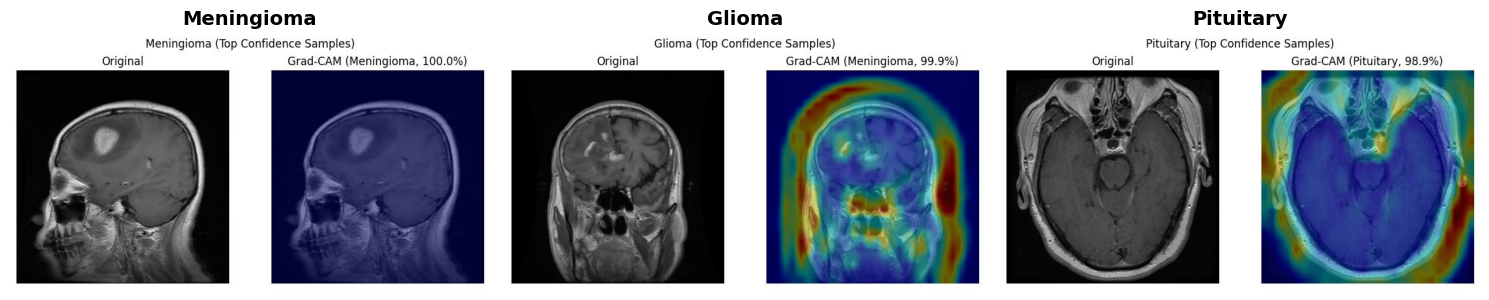

 Saved collage: /content/drive/MyDrive/gradcam_outputs_csv/GradCAM_three_examples.png


In [27]:
import cv2, matplotlib.pyplot as plt

meningioma = "/content/drive/MyDrive/gradcam_outputs_csv/Meningioma/Top_Confidence/Meningioma_Top_100_573_combined.jpg"
glioma     = "/content/drive/MyDrive/gradcam_outputs_csv/Glioma/Top_Confidence/Glioma_Top_99_749_combined.jpg"
pituitary  = "/content/drive/MyDrive/gradcam_outputs_csv/Pituitary/Top_Confidence/Pituitary_Top_98_711_combined.jpg"

# Load safely and convert to RGB
imgs = []
for path in [meningioma, glioma, pituitary]:
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f" Image not found: {path}")
    imgs.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# Create visualization
plt.figure(figsize=(15,5))
titles = ['Meningioma', 'Glioma', 'Pituitary']
for i, (img, title) in enumerate(zip(imgs, titles)):
    plt.subplot(1,3,i+1)
    plt.imshow(img)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.axis('off')

plt.tight_layout()
plt.savefig("/content/drive/MyDrive/gradcam_outputs_csv/GradCAM_three_examples.png", dpi=300)
plt.show()
print(" Saved collage: /content/drive/MyDrive/gradcam_outputs_csv/GradCAM_three_examples.png")


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 205ms/step
Model Performance Summary

              precision    recall  f1-score   support

  Meningioma      1.000     0.991     0.995       109
      Glioma      0.833     1.000     0.909         5
   Pituitary      1.000     1.000     1.000         1

    accuracy                          0.991       115
   macro avg      0.944     0.997     0.968       115
weighted avg      0.993     0.991     0.992       115



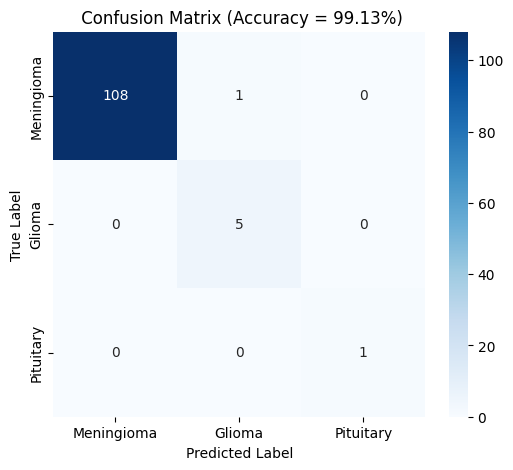

📁 Metrics saved to: /content/drive/MyDrive/brain_tumor_metrics.csv


In [28]:

#Model Evaluation: Accuracy, Precision, Recall, F1 & Confusion Matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Step 1: Generate predictions on the test set ---
# (Ensure you have X_test and y_test from your data split)
y_pred_probs = model.predict(X_test, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)

#Step 2: Compute classification metrics ---
target_names = ["Meningioma", "Glioma", "Pituitary"]

print("Model Performance Summary\n")
print(classification_report(y_test, y_pred, target_names=target_names, digits=3))

#Step 3: Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.title(f" Confusion Matrix (Accuracy = {acc*100:.2f}%)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#Step 4:saving metrrics to csv
import pandas as pd
report_dict = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
report_df.to_csv("/content/drive/MyDrive/brain_tumor_metrics.csv", index=True)
print("📁 Metrics saved to: /content/drive/MyDrive/brain_tumor_metrics.csv")


In [29]:
!ls "/content/drive/MyDrive/"



'12 &10 result'
 187.jpeg
 308B5130-E540-4146-9ABA-779E63F18969.png
 80695cdb24f44a178cc2f54b220962b9-0001.jpg
'+91 9711740806 (4).docx'
 AADHAR.pdf
'Adani Electricity Payment Receipt.pdf'
'all -6 (1).png'
 Ans.gdoc
'Associate Data Science Jobs - Nov 2025.gsheet'
 aws.gdoc
'BEST OUT OF WASTE report.docx'
'Book shop project in c++.gdoc'
'Boomerang '
 brain_tumor_cnn_functional.h5
 brain_tumor_cnn_model.h5
 brainTumorDataPublic_1766
 brain_tumor_images_final
 brain_tumor_metrics.csv
 brain_tumor_segmented
'CA-2 (sbr-hrvo-gsv - Mar 24, 2021).pdf'
 Ca2-WP-Group6.gdoc
 ceb6f88bf8ea4afd8a8c85f06620d7de-0001.jpg
'Chutku .gsheet'
 Classroom
 Clips
'Colab Notebooks'
'confirm guest list if card'
'Copy of Screenshot 2021-03-25 at 11.00.03 AM.png'
'Copy of VIBE_AM-CA2.gdoc'
'Data Science Club Constitution (1).gdoc'
'Data Science Club Constitution.gdoc'
 Dcc
'Dcc (1)'
' DePaul Data Science Club (VOLUNTEER).gform'
' DePaul Data Science Club (VOLUNTEER) (Responses).gsheet'
'DePaul DSC.gform'
'DePaul 

In [30]:
!pip install --upgrade scikit-image==0.19.3


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 52.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  error: subprocess-exited-with-error
  
  × Getting requirements to build wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Getting requirements to build wheel ... error
error: subprocess-exited-with-error

× Getting requirements to build wheel did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


Sample Images Selected:
{'Meningioma': '/content/drive/MyDrive/brain_tumor_images_final/1/46.jpg', 'Glioma': '/content/drive/MyDrive/brain_tumor_images_final/2/755.jpg', 'Pituitary': '/content/drive/MyDrive/brain_tumor_images_final/3/59.jpg'}

 Extracted GLCM Features:
Meningioma: {'Contrast': np.float64(287.91498523622045), 'Homogeneity': np.float64(0.5359925922115415), 'Energy': np.float64(0.28551865971632145), 'Correlation': np.float64(0.9368262226013507), 'Entropy': np.float64(7.78796438223968)}
Glioma: {'Contrast': np.float64(382.6977116141732), 'Homogeneity': np.float64(0.46198262323109995), 'Energy': np.float64(0.1771193931148239), 'Correlation': np.float64(0.897473925481937), 'Entropy': np.float64(8.916190457073515)}
Pituitary: {'Contrast': np.float64(467.6209399606299), 'Homogeneity': np.float64(0.2362343605696354), 'Energy': np.float64(0.05436765500018349), 'Correlation': np.float64(0.8753561674394645), 'Entropy': np.float64(11.237563675962342)}


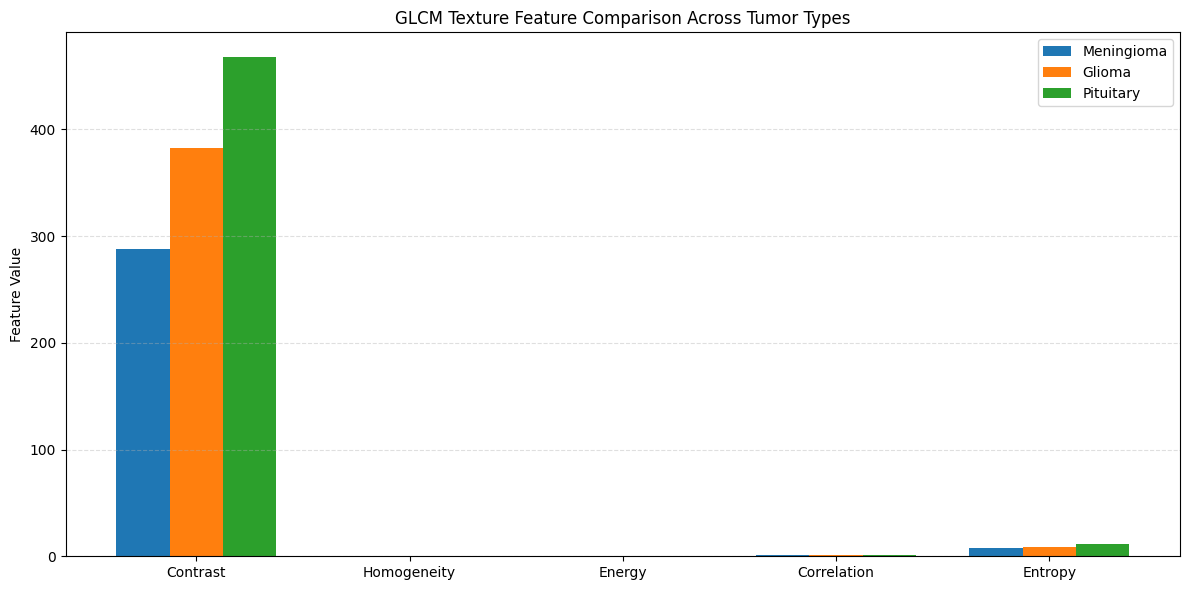

In [31]:
#GLCM Texture Analysis

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Updated imports for new scikit-image (0.24+)
from skimage.feature.texture import graycomatrix, graycoprops
#Auto-pick sample paths

base_dir = "/content/drive/MyDrive/brain_tumor_images_final"

sample_paths = {}
class_map = {
    "Meningioma": "1",
    "Glioma": "2",
    "Pituitary": "3"
}

#Automatically select first .jpg file in each folder
for label, folder in class_map.items():
    folder_path = os.path.join(base_dir, folder)
    files = [f for f in os.listdir(folder_path) if f.lower().endswith(".jpg")]

    if len(files) == 0:
        raise ValueError(f"No images found in {folder_path}")

    sample_paths[label] = os.path.join(folder_path, files[0])

print("Sample Images Selected:")
print(sample_paths)

#GLCM Feature Function
def get_glcm_features(img):
    img_8bit = (img * 255).astype(np.uint8)

    #GLCM
    glcm = graycomatrix(
        img_8bit,
        distances=[1],
        angles=[0],
        levels=256,
        symmetric=True,
        normed=True
    )

    #Extract main texture features
    features = {
        "Contrast": graycoprops(glcm, 'contrast')[0, 0],
        "Homogeneity": graycoprops(glcm, 'homogeneity')[0, 0],
        "Energy": graycoprops(glcm, 'energy')[0, 0],
        "Correlation": graycoprops(glcm, 'correlation')[0, 0],
    }

    # Manual entropy
    glcm_norm = glcm / glcm.sum()
    entropy = -np.sum(glcm_norm * np.log2(glcm_norm + 1e-10))
    features["Entropy"] = entropy

    return features
# 3. Extract features for all 3 classes

all_features = {}

for label, path in sample_paths.items():
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (128, 128)) / 255.0

    feats = get_glcm_features(img)
    all_features[label] = feats

print("\n Extracted GLCM Features:")
for cls, feats in all_features.items():
    print(f"{cls}: {feats}")
# 4Bar Plot Comparison

plt.figure(figsize=(12, 6))

feature_names = list(all_features["Meningioma"].keys())
x = np.arange(len(feature_names))
width = 0.25

men = [all_features["Meningioma"][f] for f in feature_names]
gli = [all_features["Glioma"][f] for f in feature_names]
pit = [all_features["Pituitary"][f] for f in feature_names]

plt.bar(x - width, men, width, label="Meningioma")
plt.bar(x, gli, width, label="Glioma")
plt.bar(x + width, pit, width, label="Pituitary")

plt.xticks(x, feature_names)
plt.ylabel("Feature Value")
plt.title("GLCM Texture Feature Comparison Across Tumor Types")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


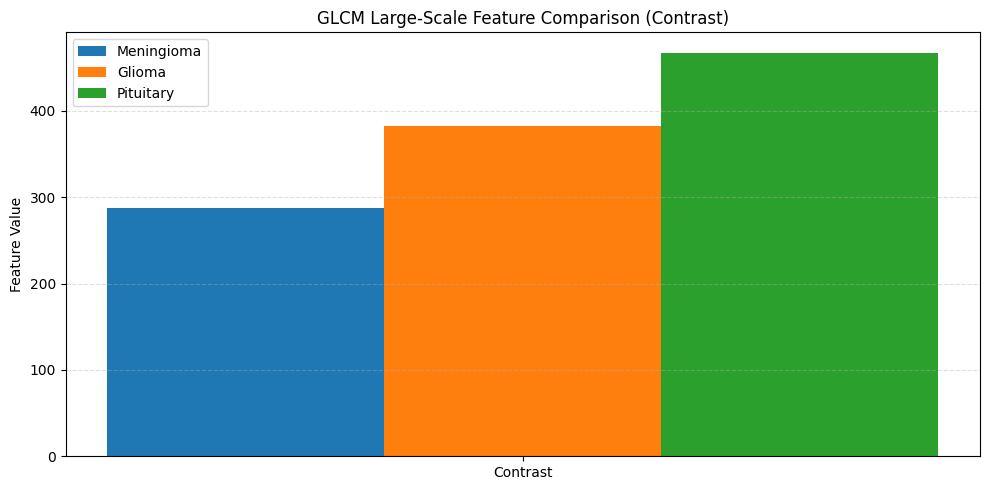

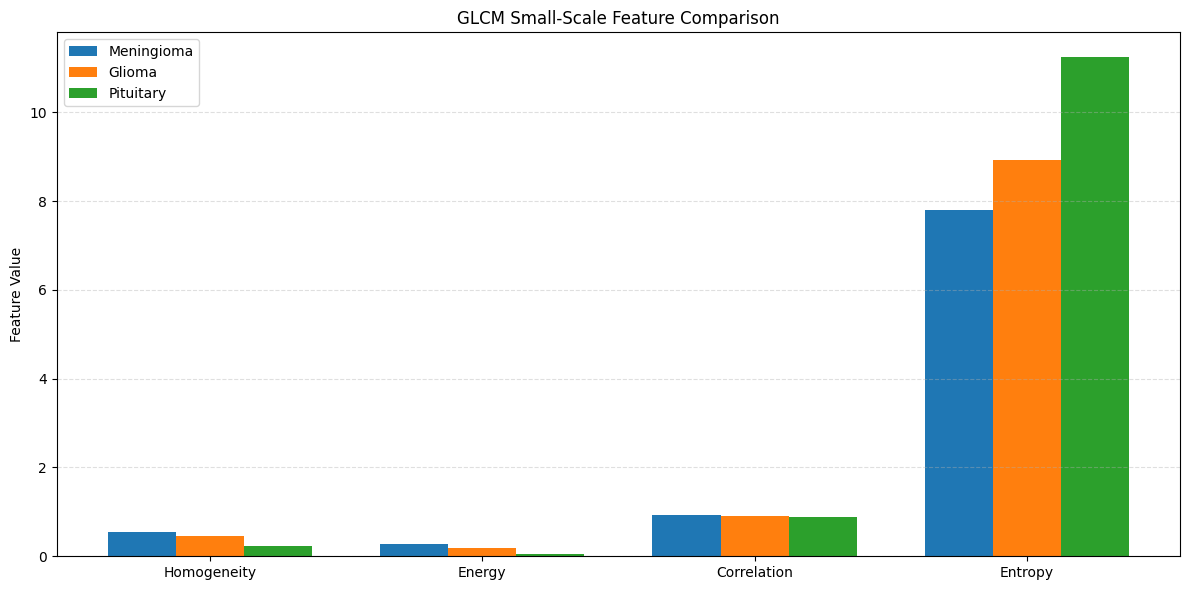

In [32]:
#Improved Visualization: Two Separate Plots

big_features = ["Contrast"]
small_features = ["Homogeneity", "Energy", "Correlation", "Entropy"]

# Big Features Plot
plt.figure(figsize=(10,5))
x = np.arange(len(big_features))
width = 0.25

plt.bar(x - width, [all_features["Meningioma"][f] for f in big_features],
        width, label="Meningioma")
plt.bar(x, [all_features["Glioma"][f] for f in big_features],
        width, label="Glioma")
plt.bar(x + width, [all_features["Pituitary"][f] for f in big_features],
        width, label="Pituitary")

plt.xticks(x, big_features)
plt.ylabel("Feature Value")
plt.title("GLCM Large-Scale Feature Comparison (Contrast)")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

# Small Features Plot
plt.figure(figsize=(12,6))
x = np.arange(len(small_features))
width = 0.25

plt.bar(x - width, [all_features["Meningioma"][f] for f in small_features],
        width, label="Meningioma")
plt.bar(x, [all_features["Glioma"][f] for f in small_features],
        width, label="Glioma")
plt.bar(x + width, [all_features["Pituitary"][f] for f in small_features],
        width, label="Pituitary")

plt.xticks(x, small_features)
plt.ylabel("Feature Value")
plt.title("GLCM Small-Scale Feature Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [33]:
for i, l in enumerate(model.layers):
    print(i, l.name, type(l))


0 conv2d_6 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
1 max_pooling2d_6 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
2 conv2d_7 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
3 max_pooling2d_7 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
4 conv2d_8 <class 'keras.src.layers.convolutional.conv2d.Conv2D'>
5 max_pooling2d_8 <class 'keras.src.layers.pooling.max_pooling2d.MaxPooling2D'>
6 flatten_2 <class 'keras.src.layers.reshaping.flatten.Flatten'>
7 dense_4 <class 'keras.src.layers.core.dense.Dense'>
8 dropout_2 <class 'keras.src.layers.regularization.dropout.Dropout'>
9 dense_5 <class 'keras.src.layers.core.dense.Dense'>


In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')


def robust_tumor_pipeline(img_path):
    #  STEP 0: Load
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(" Image path invalid:", img_path)
        return

    img = cv2.resize(img, (128,128)).astype(np.uint8)

    # STEP 1: Median Filter
    median = cv2.medianBlur(img, 5)

    #  STEP 2: Normalize to 0–255
    norm = cv2.normalize(median, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    #  STEP 3: Clip low intensities
    # This suppresses skull and background, enhances tumor contrast
    clipped = np.where(norm < 40, 0, norm).astype(np.uint8)

    # STEP 4: Extract bright region (top 15%)
    perc = np.percentile(clipped[clipped > 0], 85)  # safer percentile
    bright_mask = (clipped >= perc).astype(np.uint8) * 255

    # STEP 5: Morphology cleanup
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(bright_mask, cv2.MORPH_OPEN, kernel, iterations=1)
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, iterations=2)

    # STEP 6: Largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morph)

    if num_labels > 1:
        largest_label = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        tumor_mask = (labels == largest_label).astype(np.uint8) * 255
    else:
        tumor_mask = morph

    # STEP 7: Overlay
    overlay = cv2.addWeighted(img, 0.7, tumor_mask, 0.3, 0)

    #  STEP 8: Display
    plt.figure(figsize=(15,10))

    plt.subplot(2,3,1); show(img, "Raw Image")
    plt.subplot(2,3,2); show(median, "Median Filtered")
    plt.subplot(2,3,3); show(norm, "Normalized")

    plt.subplot(2,3,4); show(bright_mask, "Bright-Region Mask (Top 15%)")
    plt.subplot(2,3,5); show(tumor_mask, "Largest Connected Component")
    plt.subplot(2,3,6); show(overlay, "Final Tumor Overlay")

    plt.tight_layout()
    plt.show()


In [35]:
import os

folder = "/content/drive/MyDrive/brain_tumor_images_final/1"
sample_path = os.path.join(folder, os.listdir(folder)[3])
sample_path


'/content/drive/MyDrive/brain_tumor_images_final/1/272.jpg'

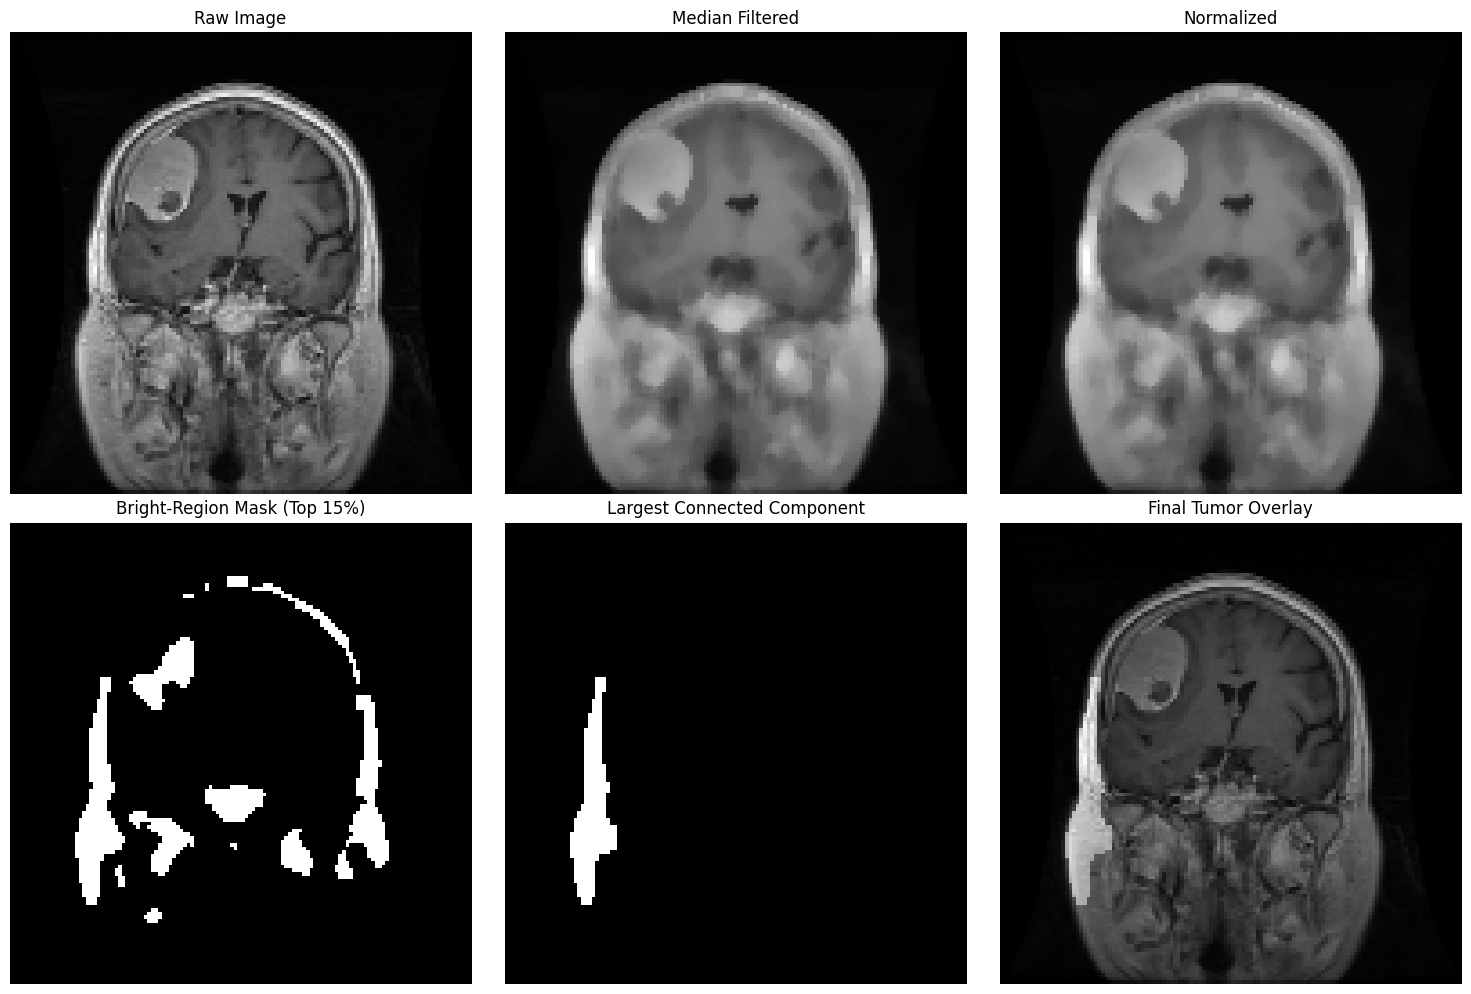

In [36]:
robust_tumor_pipeline(sample_path)


In [37]:
import cv2
import numpy as np
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

def extract_tumor_mask(img):
    img = cv2.resize(img, (128,128)).astype(np.uint8)

    # Step 1: Median filter
    den = cv2.medianBlur(img, 5)

    # Step 2: Normalize
    norm = cv2.normalize(den, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Step 3: Suppress low-intensity background
    clipped = np.where(norm < 40, 0, norm).astype(np.uint8)

    # Step 4: Brightest 15% = tumor region
    perc = np.percentile(clipped[clipped > 0], 85)
    bright = (clipped >= perc).astype(np.uint8) * 255

    # Step 5: Morphology
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(bright, cv2.MORPH_OPEN, kernel, iterations=1)
    morph = cv2.morphologyEx(morph, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Step 6: Largest connected component
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(morph)
    if num_labels > 1:
        largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
        mask = (labels == largest).astype(np.uint8) * 255
    else:
        mask = morph

    return norm, mask
input_dir = "/content/drive/MyDrive/brain_tumor_images_final"
output_dir = "/content/drive/MyDrive/brain_tumor_segmented"
os.makedirs(output_dir, exist_ok=True)

for folder in ["1", "2", "3"]:
    in_path = os.path.join(input_dir, folder)
    out_mask_path = os.path.join(output_dir, folder, "masks")
    out_overlay_path = os.path.join(output_dir, folder, "overlay")

    os.makedirs(out_mask_path, exist_ok=True)
    os.makedirs(out_overlay_path, exist_ok=True)

    for img_file in tqdm(os.listdir(in_path), desc=f"Processing class {folder}"):
        img_path = os.path.join(in_path, img_file)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        norm_img, mask = extract_tumor_mask(img)

        # Save mask
        cv2.imwrite(os.path.join(out_mask_path, img_file), mask)

        # Save overlay
        overlay = cv2.addWeighted(norm_img, 0.7, mask, 0.3, 0)
        cv2.imwrite(os.path.join(out_overlay_path, img_file), overlay)


Processing class 3: 100%|██████████| 7/7 [00:00<00:00, 33.61it/s]


In [39]:
import os

base = "/content/drive/MyDrive/brain_tumor_images_final"

for cls in ["1", "2", "3"]:
    print(f"\nClass {cls}:")
    path = os.path.join(base, cls)
    print(os.listdir(path)[:20])   # show first 20 images



Class 1:
['46.jpg', '600.jpg', '622.jpg', '272.jpg', '150.jpg', '640.jpg', '310.jpg', '161.jpg', '158.jpg', '697.jpg', '129.jpg', '96.jpg', '407.jpg', '563.jpg', '636.jpg', '372.jpg', '588.jpg', '275.jpg', '330.jpg', '219.jpg']

Class 2:
['755.jpg', '732.jpg', '723.jpg', '717.jpg', '757.jpg', '715.jpg', '749.jpg', '762.jpg', '733.jpg', '746.jpg', '738.jpg', '765.jpg', '743.jpg', '742.jpg', '724.jpg', '766.jpg', '720.jpg', '747.jpg', '734.jpg', '725.jpg']

Class 3:
['59.jpg', '709.jpg', '710.jpg', '711.jpg', '714.jpg', '713.jpg', '712.jpg']


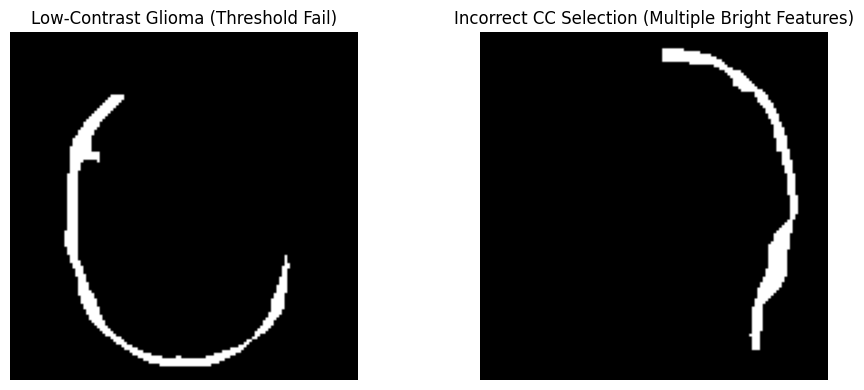

Saved to /content/failure_cases.png


In [40]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os


# Using REAL images from your folder listing


low_contrast_path = "/content/drive/MyDrive/brain_tumor_images_final/2/742.jpg"
multi_bright_path = "/content/drive/MyDrive/brain_tumor_images_final/1/600.jpg"

# Load images
img1 = cv2.imread(low_contrast_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(multi_bright_path, cv2.IMREAD_GRAYSCALE)

if img1 is None:
    print("❌ Could not load:", low_contrast_path)
if img2 is None:
    print("❌ Could not load:", multi_bright_path)

if img1 is None or img2 is None:
    raise FileNotFoundError("One or both paths are incorrect.")


# Segmentation pipeline (same as earlier)


def pipeline_fail_example(img):
    img_resized = cv2.resize(img, (128, 128))

    med = cv2.medianBlur(img_resized, 5)
    eq = cv2.equalizeHist(med)

    thresh_val = np.percentile(eq, 90)
    _, mask = cv2.threshold(eq, thresh_val, 255, cv2.THRESH_BINARY)

    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    num_labels, labels = cv2.connectedComponents(morph)

    if num_labels > 1:
        counts = np.bincount(labels.flatten())[1:]
        largest_cc = np.argmax(counts) + 1
        final_mask = (labels == largest_cc).astype(np.uint8) * 255
    else:
        final_mask = morph

    return img_resized, final_mask

orig1, mask1 = pipeline_fail_example(img1)
orig2, mask2 = pipeline_fail_example(img2)


# Plot failure cases


plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.imshow(mask1, cmap='gray')
plt.title("Low-Contrast Glioma (Threshold Fail)")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask2, cmap='gray')
plt.title("Incorrect CC Selection (Multiple Bright Features)")
plt.axis("off")

plt.tight_layout()
plt.savefig("/content/failure_cases.png", dpi=300)
plt.show()

print("Saved to /content/failure_cases.png")


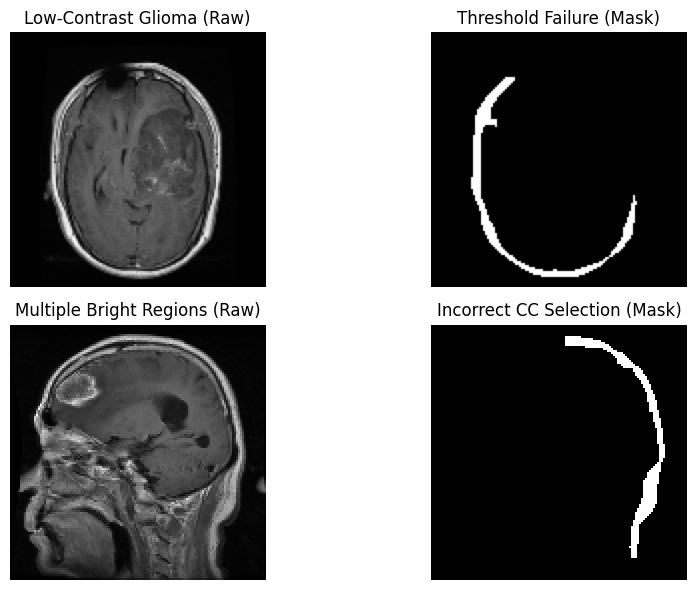

Saved enhanced failure figure to /content/failure_cases_final.png


In [41]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Use your confirmed paths
low_contrast_path = "/content/drive/MyDrive/brain_tumor_images_final/2/742.jpg"
multi_bright_path = "/content/drive/MyDrive/brain_tumor_images_final/1/600.jpg"

# Load
img1 = cv2.imread(low_contrast_path, cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread(multi_bright_path, cv2.IMREAD_GRAYSCALE)

def pipeline_fail_example(img):
    img_resized = cv2.resize(img, (128, 128))
    med = cv2.medianBlur(img_resized, 5)
    eq = cv2.equalizeHist(med)
    thresh_val = np.percentile(eq, 90)
    _, mask = cv2.threshold(eq, thresh_val, 255, cv2.THRESH_BINARY)
    kernel = np.ones((3,3), np.uint8)
    morph = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    num_labels, labels = cv2.connectedComponents(morph)
    if num_labels > 1:
        counts = np.bincount(labels.flatten())[1:]
        largest_cc = np.argmax(counts) + 1
        final_mask = (labels == largest_cc).astype(np.uint8) * 255
    else:
        final_mask = morph
    return img_resized, final_mask

# Run failures
raw1, mask1 = pipeline_fail_example(img1)
raw2, mask2 = pipeline_fail_example(img2)

# Plot (4 panels)

plt.figure(figsize=(10,6))

plt.subplot(2,2,1)
plt.imshow(raw1, cmap='gray')
plt.title("Low-Contrast Glioma (Raw)")
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(mask1, cmap='gray')
plt.title("Threshold Failure (Mask)")
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(raw2, cmap='gray')
plt.title("Multiple Bright Regions (Raw)")
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(mask2, cmap='gray')
plt.title("Incorrect CC Selection (Mask)")
plt.axis('off')

plt.tight_layout()
plt.savefig("/content/failure_cases_final.png", dpi=300)
plt.show()

print("Saved enhanced failure figure to /content/failure_cases_final.png")
